In [1]:
!nvidia-smi
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages')

import numpy as np
import matplotlib.pyplot as plt
import os
import random
import keras
import tensorflow as tf
import copy
import keras.backend as K

from PIL import Image                              
from keras import optimizers, losses, metrics, models
from keras.models import load_model
from keras.utils import to_categorical
from models.cnn_model_LSTM_many_to_one import cnn_lstm
from models.cnn_model import resnet8
from keras.utils.training_utils import multi_gpu_model

Fri Apr  9 17:26:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:05:00.0  On |                  N/A |
| 54%   57C    P8    21W / 250W |    496MiB / 11018MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:06:00.0 Off |                  N/A |
| 38%   

Using TensorFlow backend.


In [ ]:
# load data
root_path = '/home/asl/machine_learning/time_to_collision/Preprocessed_data'
img_dir = root_path + '/train_sim_image_for_CNN.npy'
label_dir = root_path + '/train_sim_label_for_CNN.npy'
# Allocate variable for train_x and train_y
img_x = np.load(img_dir)
label = np.load(label_dir)

In [ ]:
# train_x = np.zeros([len(img_x), 6, 128, 128, 1])
# # Reshape the train images
# for i in range(len(img_x)):
#     temp_img = np.moveaxis(img_x[i], 0, 2)
#     temp_img = np.reshape(img_x[i], [6, 128, 128, 1])
#     temp_img = temp_img / 255.
#     train_x[i] = temp_img

In [ ]:
# Shuffle the data
print("Number of data:{}".format(len(img_x)))
rand_index = np.random.permutation(len(img_x))
train_x = img_x[rand_index]
label = label[rand_index]

In [ ]:
del img_x

In [ ]:
# Check the label
n = np.arange(len(train_x))
plt.figure(figsize = (16,9))
plt.scatter(n, label[n])
print(np.sum(label<6))
plt.ylim([0,1.5])
plt.show()

In [ ]:
# visualization of training data
n = np.random.randint(len(train_x))
print("True time to collision: {}".format(label[n]))

sample = train_x[n]
print("Shape of the data:{}".format(np.shape(sample)))
sample_y = label[n]
fig = plt.figure(figsize = (10,8))

_sample = np.reshape(sample[:,:,:],[128, 128, 3]) / 255.
ax = fig.add_subplot(2,3,1)
ax.imshow(_sample)
ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0)
plt.show()

# fig.savefig('sample_input.png', dpi = 600, bbox_inches = 'tight')

In [ ]:
# data split for train, validation, and test

n = np.int(len(train_x)* 0.8)
m = np.int(len(label)*0.9)

# train 
train_img = train_x[:n] / 255.
train_img = np.reshape(train_img, [-1, 128,128,3])
train_y = label[:n]

# validation
valid_img = train_x[n:m] / 255.
valid_img = np.reshape(valid_img, [-1, 128,128,3])
valid_y = label[n:m]

# test
test_img = train_x[m:] / 255.
test_img = np.reshape(test_img, [-1, 128, 128, 3])
test_y = label[m:]

#check size

print("Training data size: {}".format(np.shape(train_img)))
print("Training y size: {}".format(np.shape(train_y)))
print("Validation data size: {}".format(np.shape(valid_img)))
print("Test data size: {}".format(np.shape(test_img)))

In [2]:
def getModel(img_width, img_height, img_channels, output_dim, model_path):
    model = resnet8(img_width, img_height, img_channels, output_dim)
    
    if model_path:
        try:
            model.load_weights(model_path)
            print("Loaded model from {}".format(model_path))
        
        except:
            print("Impossible to find weight path. Train new model.")
    return model

In [ ]:
def mean_loss(log_var, mean):
    def customLoss(yTrue, yPred):
        loss1 = K.exp(-log_var) * K.square(K.abs(yTrue - mean))
        return loss1
    return customLoss
    
def var_loss(log_var):
    def customLoss(yTrue, yPred):
        loss2 = log_var        
        return loss2
    return customLoss

In [3]:
# define model and optimizer
est_coll_model = multi_gpu_model(getModel(128, 128, 3, 1, 'None'), gpus=2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 31, 31, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 31, 31, 32)   128      

In [ ]:
var_layer = est_coll_model.get_layer('variance').output
mean_layer = est_coll_model.get_layer('mean').output
opti = optimizers.Adam(lr= 5e-7, decay = 1e-5)
est_coll_model.compile(optimizer= opti, loss = [mean_loss(var_layer, mean_layer), var_loss(var_layer)], loss_weights = [0.5, 0.5])

In [ ]:
callbacks_list = [    
    keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience= 50,
    ),
    keras.callbacks.TensorBoard(
    log_dir = 'log_dir/GAN_model/CNN_sim_image',
    histogram_freq=1,),
    keras.callbacks.ModelCheckpoint(
        filepath='./cnn_saved_models/GAN_model/CNN_sim_image.h5',
        save_best_only=True,
        save_weights_only=True,
        verbose=1)    
]

In [ ]:
history = est_coll_model.fit(train_img, [train_y, train_y],
                             validation_data=[valid_img ,[valid_y, valid_y]],
                             epochs=1500,
                             batch_size=128,
                             callbacks = callbacks_list)

In [ ]:
import time

error_matrix = []

n = np.random.randint(len(test_y))
for k in range(len(test_y)):
    s = time.time()
    
    y_eval = []
    aletoric = []
    epistemic = []
    
    for i in range(5):      
        temp_input = np.reshape(test_img[k], [-1, 128, 128, 3])
        _mean, _var = est_coll_model.predict(temp_input)    
        y_eval.append(_mean)    
        epistemic.append(_mean)
        aletoric.append(_var)

    epistemic_uncertainty = np.sqrt(np.var(epistemic))
    aletoric_uncertainty = np.sqrt(np.mean((np.exp(aletoric))))
    total_uncertainty = epistemic_uncertainty + aletoric_uncertainty
    y_eval = np.mean(y_eval)

    e = time.time() - s 
    error_matrix.append(np.abs(test_y[k] - y_eval))
print("Error:{}".format(np.mean(error_matrix)))

plt.figure()
plt.vlines(test_y[n],ymin=0, ymax=5, color = 'r', label='true')
plt.vlines(y_eval, ymin=0,ymax=5, color='b', label='estimate')
plt.axvspan(y_eval - epistemic_uncertainty, y_eval + epistemic_uncertainty, ymin=0, ymax=5, color='blue', alpha=0.3, label='epistemic')
plt.axvspan(y_eval - aletoric_uncertainty, y_eval + aletoric_uncertainty, ymin=0, ymax=5, color='grey', alpha=0.3, label='aletoric')
plt.axvspan(y_eval - total_uncertainty , y_eval + total_uncertainty, ymin=0, ymax=5, color='black', alpha=0.4, label = 'total')
plt.xlim([-1,8])
plt.legend()
plt.grid()
plt.show()

## Error value for test data set: 1.149 sec

In [8]:
# load_model
# est_coll_model.load_weights('./cnn_saved_models/GAN_model/CNN_sim_image.h5')
est_coll_model.load_weights('./cnn_saved_models/GAN_model/CNN_Color.h5')

In [9]:
total_error = []

7
Total_error:2.2515899786135045
Error variance:2.0265423793027164
Uncertainty:2.500142812728882


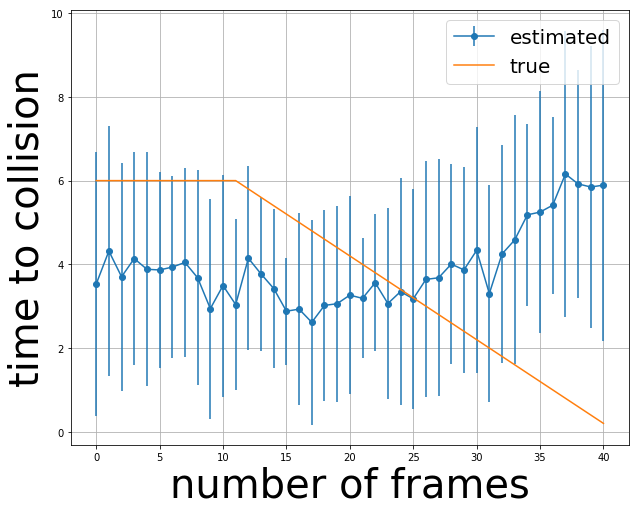

8
Total_error:2.385382743676504
Error variance:0.24627438331147974
Uncertainty:2.0846078395843506


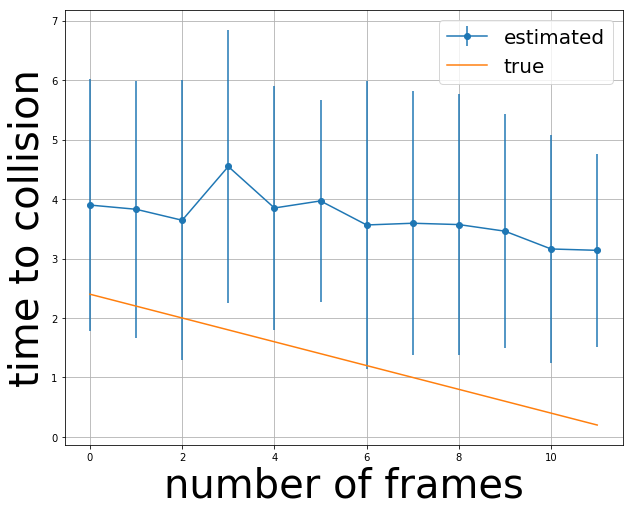

9
Total_error:1.0949825398465414
Error variance:0.8557252187884063
Uncertainty:2.0236756801605225


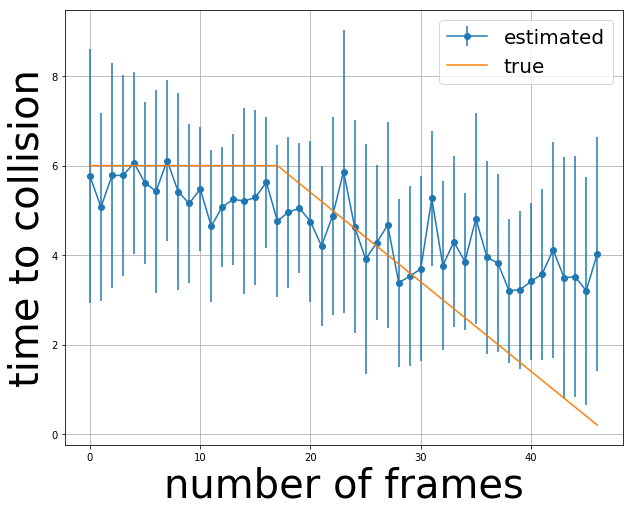

10
Total_error:1.9360998209785019
Error variance:2.0039773433949897
Uncertainty:2.9628260135650635


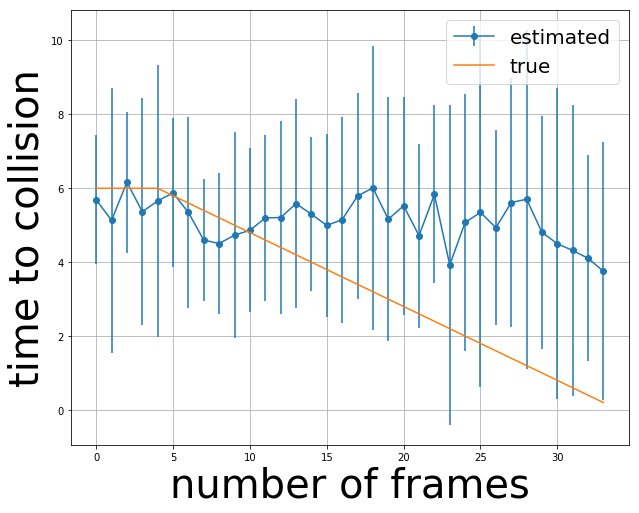

11
Total_error:1.64516889333725
Error variance:1.0715918984373203
Uncertainty:2.825340747833252


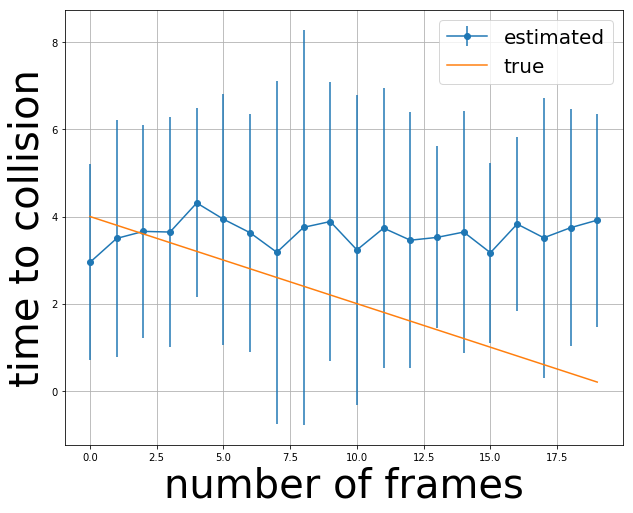

12
Total_error:2.0266223952174185
Error variance:1.3007729265276897
Uncertainty:2.4140076637268066


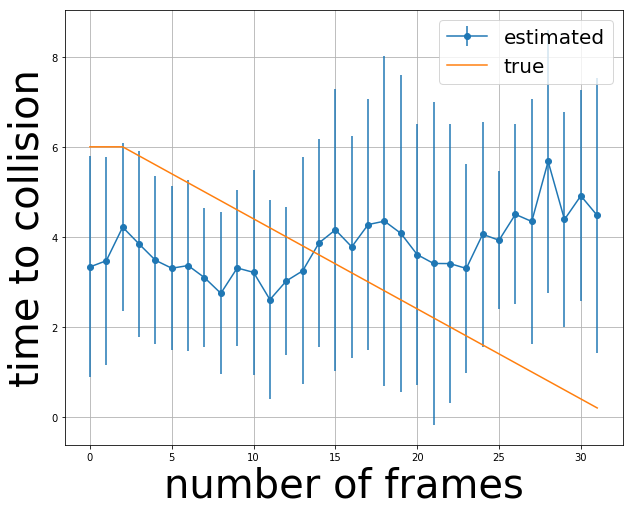

13
Total_error:1.4154909116881236
Error variance:0.7725747624916754
Uncertainty:2.111149787902832


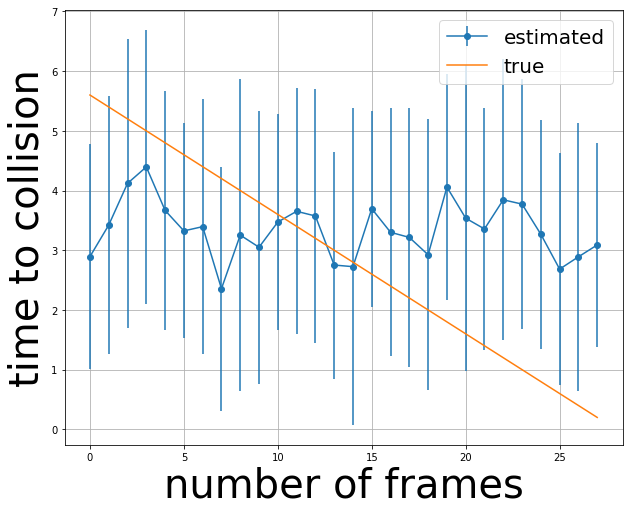

14
Total_error:1.8952672769857
Error variance:1.0005982403135365
Uncertainty:2.9441545009613037


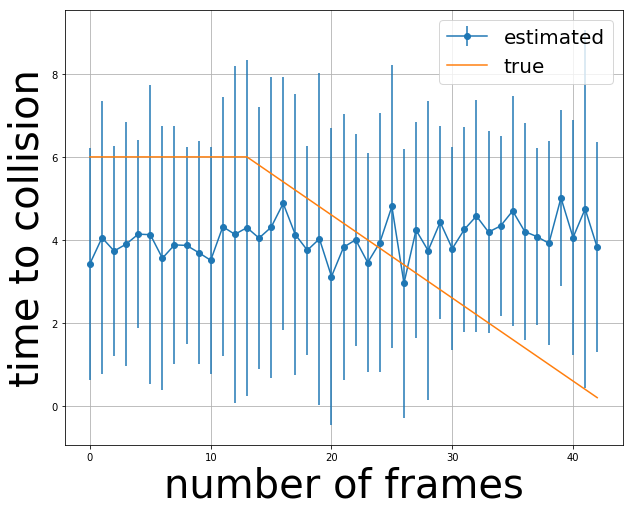

15
Total_error:1.449398705833837
Error variance:0.6867415858833702
Uncertainty:2.1189022064208984


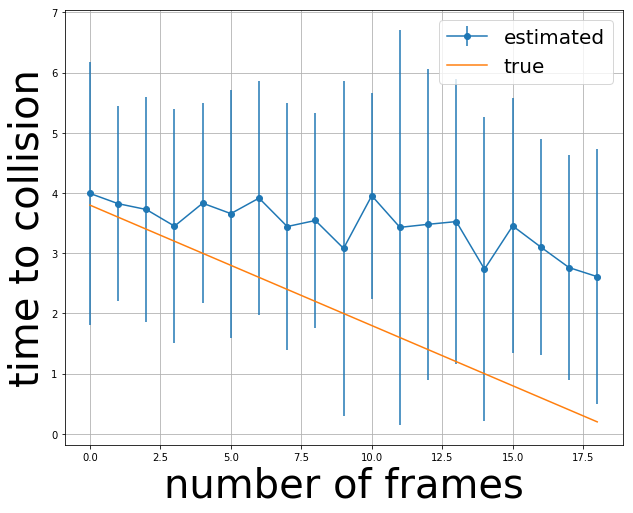

16
Total_error:1.335067080006455
Error variance:0.4917768564339203
Uncertainty:2.092921733856201


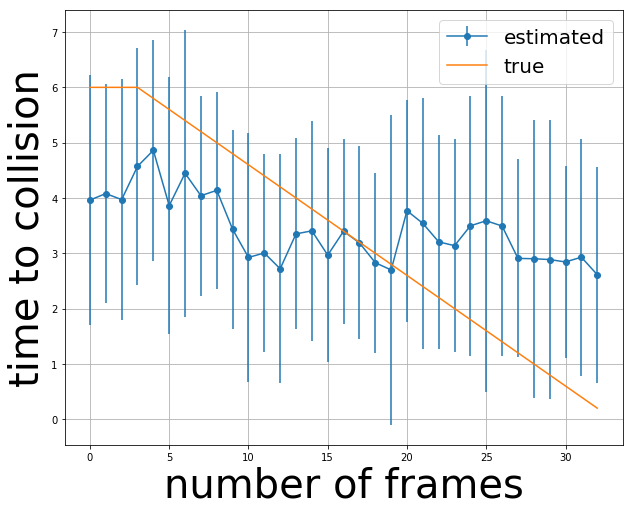

17
Total_error:1.5585576501385918
Error variance:0.5073428863772128
Uncertainty:2.9758331775665283


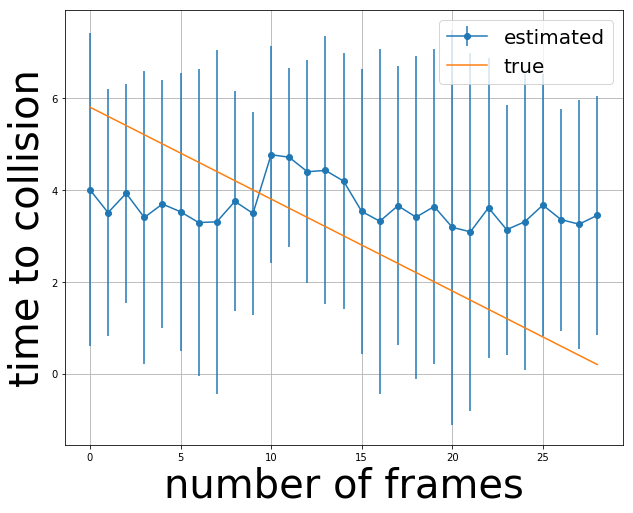

18
Total_error:1.3608684228814165
Error variance:1.6631123688285019
Uncertainty:2.215228796005249


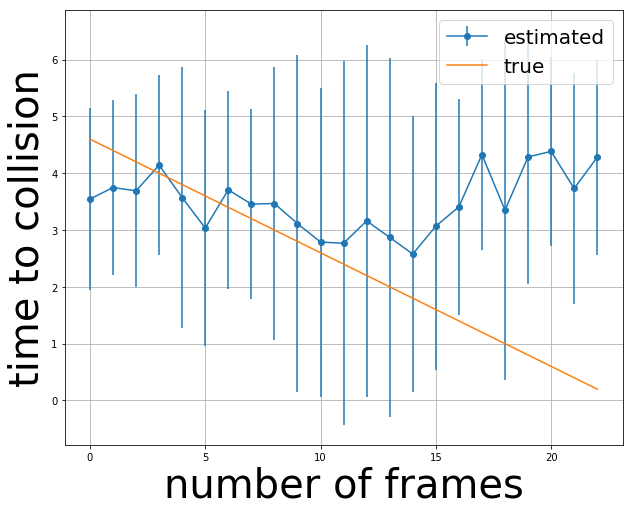

19
Total_error:1.6363691510825316
Error variance:1.1026676237289723
Uncertainty:3.124730348587036


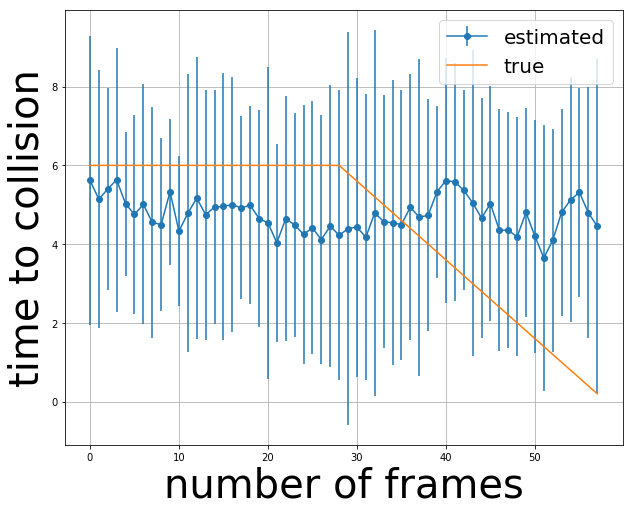

1.7067844519694984
0.32749172692234413


In [11]:
for episode in range(7,20):
    print(episode)
    
    # Check the model performance using totally unseen data
    root_path = '/home/asl/machine_learning/time_to_collision/Preprocessed_data/Parrot_data/image_new_for_CNN'    
    new_img_dir = root_path + '/img_' + str(episode) + '.npy'
    new_label_dir = root_path + '/label_' + str(episode) + '.npy'

    # Allocate variable for train_x and train_y
    new_test_img = np.load(new_img_dir) / 255.
    new_test_y = np.load(new_label_dir)
    new_test_y = new_test_y # give offset for wrong crash distance

    label_index = new_test_y > 6
    new_test_y[label_index] = 6

    # For visualizing t2c values    
    true_label = []
    estimated_label = []  
    
    # visualization of training data
    error_matrix = []
    uncertainty_matrix = []

    for j in range(len(new_test_img)):
        sample = new_test_img[j]
        temp_input = np.reshape(sample, [-1, 128, 128, 3])

        y_eval = []
        aleatoric = []
        epistemic = []

        for i in range(5):
            _mean, _var = est_coll_model.predict(temp_input)    
            y_eval.append(_mean)    
            epistemic.append(_mean)
            aleatoric.append(_var)   

        epistemic_uncertainty = np.sqrt(np.var(epistemic))
        aleatoric_uncertainty = np.sqrt(np.mean((np.exp(aleatoric))))
        total_uncertainty = epistemic_uncertainty + aleatoric_uncertainty
        y_eval = np.mean(y_eval)
        uncertainty_matrix.append(total_uncertainty)    

        sample = new_test_img[j]
        sample = np.reshape(sample, [-1, 128, 128, 3])
        sample_y = new_test_y[j]
        error_matrix.append(np.abs(sample_y - y_eval))
        
        # store true and estimated values 
        true_label.append(sample_y)
        estimated_label.append(y_eval)
        
        # show figure of the parrot image
#         fig = plt.figure(figsize = (10,8))
#         _sample = np.reshape(sample, [128, 128, 3])                 
#         plt.imshow(_sample)                
#         plt.show()

#         plt.figure()
#         plt.vlines(sample_y,ymin=0, ymax=6, color = 'r', label='true')
#         plt.vlines(y_eval, ymin=0,ymax=6, color='b', label='estimate')
#         plt.axvspan(y_eval - aleatoric_uncertainty, y_eval + aleatoric_uncertainty, ymin=0, ymax=6, color='green', alpha=0.3, label = 'aleatoric')
#         plt.axvspan(y_eval - epistemic_uncertainty, y_eval + epistemic_uncertainty, ymin=0, ymax=6, color='blue', alpha=0.3, label = 'epistemic')
#         plt.axvspan(y_eval - total_uncertainty, y_eval + total_uncertainty, ymin=0, ymax=6, color='grey', alpha=0.6, label = 'total uncertainty')
#         plt.xlim([0,6])
#         plt.legend()
#         plt.grid()
#         plt.show()
    
    total_error.append(np.mean(error_matrix))
    print("Total_error:{}".format(np.mean(error_matrix)))
    print("Error variance:{}".format(np.var(error_matrix)))
    print("Uncertainty:{}".format(np.mean(uncertainty_matrix)))
    
    fig2 = plt.figure(figsize=(10,8))
    plt.errorbar(np.arange(len(estimated_label)), estimated_label, yerr = uncertainty_matrix, marker = 'o', label = 'estimated')
    plt.errorbar(np.arange(len(true_label)), true_label, label = 'true')
    plt.legend(fontsize = '20')
    plt.grid()
    plt.ylabel('time to collision', fontsize = '40')
    plt.xlabel('number of frames', fontsize = '40')
    plt.show()   
        
#     fig2.savefig('./CNN' + str(episode) + '.png', dpi = 600, bbox_inches = 'tight')
print(np.mean(total_error))
print(np.std(total_error))

### CNN_sim_image error: 1.55 sec/ std: 0.477 sec
### CNN_GAN_image: 1.72 sec / std: 0.316 sec

In [ ]:
# Check the model performance using totally unseen data
root_path = '/home/asl/machine_learning/time_to_collision/Preprocessed_data/crazyflie_image'
new_img_dir = root_path + '/test_image.npy'
new_label_dir = root_path + '/test_label.npy'

# Allocate variable for train_x and train_y
new_test_img = np.load(new_img_dir) / 255.0
new_test_y = np.load(new_label_dir)

In [ ]:
# visualization of training data
error_matrix = []
uncertainty_matrix = []

for j in range(len(new_test_img)):
    sample = new_test_img[j]
    temp_input = np.reshape(sample, [-1, 128, 128, 3])
    
    y_eval = []
    aleatoric = []
    epistemic = []

    for i in range(5):

        _mean, _var = est_coll_model.predict(temp_input)    
        y_eval.append(_mean)    
        epistemic.append(_mean)
        aleatoric.append(_var)   

    epistemic_uncertainty = np.sqrt(np.var(epistemic))
    aleatoric_uncertainty = np.sqrt(np.mean((np.exp(aleatoric))))
    total_uncertainty = epistemic_uncertainty + aleatoric_uncertainty
    y_eval = np.mean(y_eval)
    uncertainty_matrix.append(total_uncertainty)    
    print(y_eval)
    
    sample = new_test_img[j]
    sample = np.reshape(sample, [6, 128, 128, 3])
    sample_y = new_test_y[j]
    error_matrix.append(np.abs(sample_y - y_eval))

    fig = plt.figure(figsize = (10,8))
    for i in range(6):
        _sample = np.reshape(sample[i], [128, 128, 3]) 
        ax = fig.add_subplot(2,3,i+1)
        ax.imshow(_sample)
        ax.set_title('Time step:t_' + str(i))
        ax.axis('off')
    plt.subplots_adjust(wspace=0.02, hspace=0)
    plt.show()

    
    plt.figure()
    plt.vlines(sample_y,ymin=0, ymax=6, color = 'r', label='true')
    plt.vlines(y_eval, ymin=0,ymax=6, color='b', label='estimate')
    plt.axvspan(y_eval - aleatoric_uncertainty, y_eval + aleatoric_uncertainty, ymin=0, ymax=6, color='green', alpha=0.3, label = 'aleatoric')
    plt.axvspan(y_eval - epistemic_uncertainty, y_eval + epistemic_uncertainty, ymin=0, ymax=6, color='blue', alpha=0.3, label = 'epistemic')
    plt.axvspan(y_eval - total_uncertainty, y_eval + total_uncertainty, ymin=0, ymax=6, color='grey', alpha=0.6, label = 'total uncertainty')
    plt.xlim([0,6])
    plt.legend()
    plt.grid()
    plt.show()
    
print("Total_error:{}".format(np.mean(error_matrix)))
print("Error variance:{}".format(np.var(error_matrix)))
print("Uncertainty:{}".format(np.mean(uncertainty_matrix)))